# **Deforum Stable Diffusion (v0.7.1)**
⚠️ **NOTICE: This project is no longer maintained.** ⚠️
This repository is no longer actively maintained or updated. Users are advised to find alternative solutions or fork the project if they wish to continue development.

In [ ]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

Tesla T4, 15360 MiB, 15101 MiB


# Setup

In [ ]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys


def setup_environment():
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        start_time = time.time()
        packages = [
            'xformers',
            'einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6',
            'ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4',
            'safetensors kornia accelerate jsonmerge matplotlib resize-right',
            'scikit-learn numpngw pydantic scikit-image==0.19.3'
        ]
        for package in packages:
            print(f"..installing {package}")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + package.split())
        if not os.path.exists("deforum-stable-diffusion"):
            subprocess.check_call(['git', 'clone', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
        else:
            print(f"..deforum-stable-diffusion already exists")
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend(['deforum-stable-diffusion/','deforum-stable-diffusion/src',])
        end_time = time.time()
        print(f"..environment set up in {end_time-start_time:.0f} seconds")
    else:
        sys.path.extend(['src'])
        print("..skipping setup")

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts

..installing xformers
..installing einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6
..installing ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4
..installing safetensors kornia accelerate jsonmerge matplotlib resize-right
..installing scikit-learn numpngw pydantic scikit-image==0.19.3
..environment set up in 30 seconds


In [ ]:
#@markdown **Path Setup**

def PathSetup():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())
root.models_path, root.output_path = get_model_output_paths(root)

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [ ]:
#@markdown **Model Setup**

def ModelSetup():
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "custom" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "/content/drive/MyDrive/AI/models/sxzLuma_09XVAE.safetensors" #@param {type:"string"}
    return locals()

root.__dict__.update(ModelSetup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/sxzLuma_09XVAE.safetensors
..loading model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Settings

In [ ]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 350 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(0)"#@param {type:"string"}
    translation_x = "0: (-0.05), 1: (-0.05), 2: (-0.05), 3: (-0.05), 4: (-0.05), 5: (-0.05), 6: (-0.05), 7: (-0.06), 8: (-0.06), 9: (-0.06), 10: (-0.06), 11: (-0.07), 12: (-0.07), 13: (-0.07), 14: (-0.08), 15: (-0.08), 16: (-0.08), 17: (-0.09), 18: (-0.09), 19: (-0.10), 20: (-0.11), 21: (-0.11), 22: (-0.12), 23: (-0.12), 24: (-0.13), 25: (-0.14), 26: (-0.15), 27: (-0.16), 28: (-0.16), 29: (-0.17), 30: (-0.18), 31: (-0.19), 32: (-0.20), 33: (-0.21), 34: (-0.23), 35: (-0.24), 36: (-0.25), 37: (-0.26), 38: (-0.28), 39: (-0.29), 40: (-0.31), 41: (-0.32), 42: (-0.34), 43: (-0.36), 44: (-0.38), 45: (-0.40), 46: (-0.42), 47: (-0.44), 48: (-0.47), 49: (-0.49), 50: (-0.52), 51: (-0.55), 52: (-0.58), 53: (-0.61), 54: (-0.65), 55: (-0.69), 56: (-0.73), 57: (-0.78), 58: (-0.84), 59: (-0.91), 60: (-0.99), 61: (-1.10), 62: (-1.37), 63: (-1.64), 64: (-1.89), 65: (-2.14), 66: (-2.36), 67: (-2.59), 68: (-2.79), 69: (-2.99), 70: (-3.18), 71: (-3.36), 72: (-3.53), 73: (-3.69), 74: (-3.85), 75: (-4.01), 76: (-4.15), 77: (-4.29), 78: (-4.43), 79: (-4.55), 80: (-4.68), 81: (-4.80), 82: (-4.91), 83: (-5.02), 84: (-5.12), 85: (-5.22), 86: (-5.32), 87: (-5.41), 88: (-5.50), 89: (-5.58), 90: (-5.66), 91: (-5.74), 92: (-5.81), 93: (-5.88), 94: (-5.94), 95: (-6.00), 96: (-6.06), 97: (-6.11), 98: (-6.16), 99: (-6.21), 100: (-6.26), 101: (-6.30), 102: (-6.34), 103: (-6.37), 104: (-6.40), 105: (-6.43), 106: (-6.45), 107: (-6.48), 108: (-6.50), 109: (-6.51), 110: (-6.52), 111: (-6.53), 112: (-6.54), 113: (-6.55), 114: (-6.55), 115: (-6.54), 116: (-6.54), 117: (-6.53), 118: (-6.52), 119: (-6.51), 120: (-6.49), 121: (-6.47), 122: (-6.45), 123: (-6.42), 124: (-6.40), 125: (-6.36), 126: (-6.33), 127: (-6.29), 128: (-6.25), 129: (-6.21), 130: (-6.17), 131: (-6.12), 132: (-6.07), 133: (-6.01), 134: (-5.95), 135: (-5.89), 136: (-5.83), 137: (-5.76), 138: (-5.70), 139: (-5.62), 140: (0)"#@param {type:"string"}
    translation_y = "0: (0), 1: (0.02), 2: (-0.01), 3: (-0.03), 4: (-0.05), 5: (-0.07), 6: (-0.09), 7: (-0.11), 8: (-0.13), 9: (-0.14), 10: (-0.16), 11: (-0.18), 12: (-0.20), 13: (-0.22), 14: (-0.23), 15: (-0.25), 16: (-0.27), 17: (-0.28), 18: (-0.30), 19: (-0.31), 20: (-0.33), 21: (-0.34), 22: (-0.36), 23: (-0.37), 24: (-0.39), 25: (-0.40), 26: (-0.41), 27: (-0.43), 28: (-0.44), 29: (-0.45), 30: (-0.46), 31: (-0.48), 32: (-0.49), 33: (-0.50), 34: (-0.51), 35: (-0.52), 36: (-0.53), 37: (-0.54), 38: (-0.55), 39: (-0.56), 40: (-0.57), 41: (-0.58), 42: (-0.59), 43: (-0.59), 44: (-0.60), 45: (-0.61), 46: (-0.62), 47: (-0.62), 48: (-0.63), 49: (-0.64), 50: (-0.64), 51: (-0.65), 52: (-0.65), 53: (-0.66), 54: (-0.66), 55: (-0.66), 56: (-0.67), 57: (-0.67), 58: (-0.67), 59: (-0.68), 60: (-0.68), 61: (-0.68), 62: (-0.68), 63: (-0.68), 64: (-0.68), 65: (-0.68), 66: (-0.68), 67: (-0.68), 68: (-0.68), 69: (-0.67), 70: (-0.67), 71: (-0.67), 72: (-0.67), 73: (-0.66), 74: (-0.66), 75: (-0.65), 76: (-0.65), 77: (-0.64), 78: (-0.63), 79: (-0.63), 80: (-0.62), 81: (-0.61), 82: (-0.60), 83: (-0.59), 84: (-0.58), 85: (-0.57), 86: (-0.56), 87: (-0.54), 88: (-0.53), 89: (-0.52), 90: (-0.50), 91: (-0.49), 92: (-0.47), 93: (-0.45), 94: (-0.43), 95: (-0.41), 96: (-0.40), 97: (-0.37), 98: (-0.35), 99: (-0.33), 100: (-0.31), 101: (-0.28), 102: (-0.25), 103: (-0.23), 104: (-0.20), 105: (-0.17), 106: (-0.14), 107: (-0.11), 108: (-0.07), 109: (-0.04), 110: (-0.00), 111: (0.04), 112: (0.08), 113: (0.12), 114: (0.16), 115: (0.21), 116: (0.26), 117: (0.31), 118: (0.36), 119: (0.41), 120: (0.47), 121: (0.53), 122: (0.60), 123: (0.66), 124: (0.73), 125: (0.81), 126: (0.89), 127: (0.97), 128: (1.06), 129: (1.16), 130: (1.26), 131: (1.37), 132: (1.49), 133: (1.62), 134: (1.76), 135: (1.92), 136: (2.10), 137: (2.31), 138: (2.56), 139: (2.88), 140: (3.36), 141: (3.64), 142: (3.89), 143: (4.09), 144: (4.27), 145: (4.42), 146: (4.56), 147: (4.69), 148: (4.80), 149: (4.90), 150: (4.98), 151: (5.07), 152: (5.14), 153: (5.20), 154: (5.26), 155: (5.31), 156: (5.36), 157: (5.40), 158: (5.44), 159: (5.47), 160: (5.50), 161: (5.53), 162: (5.55), 163: (5.57), 164: (5.58), 165: (5.59), 166: (5.60), 167: (5.61), 168: (5.61), 169: (5.61), 170: (5.61), 171: (5.61), 172: (5.60), 173: (5.60), 174: (5.59), 175: (5.58), 176: (5.56), 177: (5.55), 178: (5.53), 179: (5.52), 180: (5.50), 181: (5.48), 182: (5.46), 183: (5.43), 184: (5.41), 185: (5.38), 186: (5.36), 187: (5.33), 188: (5.30), 189: (5.27), 190: (5.24), 191: (5.21), 192: (5.17), 193: (5.14), 194: (5.10), 195: (5.07), 196: (5.03), 197: (4.99), 198: (4.95), 199: (4.91), 200: (4.87), 201: (4.83), 202: (4.79), 203: (4.75), 204: (4.71), 205: (4.66), 206: (4.62), 207: (4.57), 208: (4.53), 209: (4.48), 210: (4.44), 211: (4.39), 212: (4.34), 213: (4.29), 214: (4.24), 215: (4.19), 216: (4.14), 217: (4.09), 218: (4.04), 219: (3.99), 220: (3.94), 221: (3.89), 222: (3.84), 223: (3.79), 224: (3.73), 225: (3.68), 226: (3.63), 227: (3.57), 228: (3.52), 229: (3.46), 230: (3.41), 231: (3.35), 232: (3.30), 233: (3.24), 234: (3.19), 235: (3.13), 236: (3.07), 237: (3.02), 238: (2.96), 239: (2.90), 240: (2.85), 241: (2.79), 242: (2.73), 243: (2.68), 244: (2.62), 245: (2.56), 246: (2.50), 247: (2.45), 248: (2.39), 249: (2.33), 250: (2.27), 251: (2.21), 252: (2.16), 253: (2.10), 254: (2.04), 255: (1.98), 256: (1.92), 257: (1.87), 258: (1.81), 259: (1.75), 260: (1.70), 261: (1.64), 262: (1.58), 263: (1.52), 264: (1.47), 265: (1.41), 266: (1.35), 267: (1.30), 268: (1.24), 269: (1.19), 270: (1.13), 271: (1.08), 272: (1.03), 273: (0.97), 274: (0.92), 275: (0.87), 276: (0.82), 277: (0.77), 278: (0.72), 279: (0.67), 280: (0.62), 281: (0.57), 282: (0.52), 283: (0.48), 284: (0.43), 285: (0.39), 286: (0.35), 287: (0.31), 288: (0.27), 289: (0.23), 290: (0.19), 291: (0.16), 292: (0.13), 293: (0.10), 294: (0.08), 295: (0.06), 296: (0.04), 297: (0.03), 298: (0.02), 299: (0)"#@param {type:"string"}
    translation_z = " 0: (0.02), 1: (0.02), 2: (0.01), 3: (0.01), 4: (0.01), 5: (-0.00), 6: (-0.01), 7: (-0.02), 8: (-0.03), 9: (-0.04), 10: (-0.05), 11: (-0.06), 12: (-0.07), 13: (-0.09), 14: (-0.10), 15: (-0.12), 16: (-0.14), 17: (-0.15), 18: (-0.17), 19: (-0.19), 20: (-0.21), 21: (-0.24), 22: (-0.26), 23: (-0.28), 24: (-0.31), 25: (-0.33), 26: (-0.36), 27: (-0.38), 28: (-0.41), 29: (-0.44), 30: (-0.47), 31: (-0.50), 32: (-0.54), 33: (-0.57), 34: (-0.61), 35: (-0.64), 36: (-0.68), 37: (-0.72), 38: (-0.76), 39: (-0.80), 40: (-0.84), 41: (-0.88), 42: (-0.93), 43: (-0.97), 44: (-1.02), 45: (-1.07), 46: (-1.12), 47: (-1.17), 48: (-1.22), 49: (-1.27), 50: (-1.33), 51: (-1.39), 52: (-1.45), 53: (-1.51), 54: (-1.57), 55: (-1.64), 56: (-1.70), 57: (-1.77), 58: (-1.84), 59: (-1.91), 60: (-1.99), 61: (-2.07), 62: (-2.14), 63: (-2.23), 64: (-2.31), 65: (-2.39), 66: (-2.46), 67: (-2.53), 68: (-2.59), 69: (-2.64), 70: (-2.69), 71: (-2.73), 72: (-2.78), 73: (-2.81), 74: (-2.85), 75: (-2.88), 76: (-2.91), 77: (-2.93), 78: (-2.96), 79: (-2.98), 80: (-3.00), 81: (-3.01), 82: (-3.02), 83: (-3.04), 84: (-3.04), 85: (-3.05), 86: (-3.06), 87: (-3.06), 88: (-3.06), 89: (-3.05), 90: (-3.05), 91: (-3.04), 92: (-3.04), 93: (-3.02), 94: (-3.01), 95: (-3.00), 96: (-2.98), 97: (-2.96), 98: (-2.94), 99: (-2.91), 100: (-2.89), 101: (-2.86), 102: (-2.83), 103: (-2.79), 104: (-2.76), 105: (-2.72), 106: (-2.68), 107: (-2.63), 108: (-2.58), 109: (-2.53), 110: (-2.48), 111: (-2.42), 112: (-2.36), 113: (-2.29), 114: (-2.22), 115: (-2.15), 116: (-2.07), 117: (-1.98), 118: (-1.89), 119: (-1.80), 120: (-1.69), 121: (-1.58), 122: (-1.47), 123: (-1.34), 124: (-1.20), 125: (-1.05), 126: (-0.88), 127: (-0.69), 128: (-0.48), 129: (-0.24), 130: (0)"#@param {type:"string"}
    rotation_3d_x = "0: (0), 90: (0.02), 91: (0.07), 92: (0.12), 93: (0.17), 94: (0.22), 95: (0.26), 96: (0.31), 97: (0.35), 98: (0.38), 99: (0.42), 100: (0.45), 101: (0.48), 102: (0.51), 103: (0.54), 104: (0.57), 105: (0.59), 106: (0.61), 107: (0.63), 108: (0.65), 109: (0.66), 110: (0.68), 111: (0.69), 112: (0.70), 113: (0.71), 114: (0.71), 115: (0.71), 116: (0.72), 117: (0.71), 118: (0.71), 119: (0.71), 120: (0.70), 121: (0.69), 122: (0.68), 123: (0.66), 124: (0.65), 125: (0.63), 126: (0.61), 127: (0.58), 128: (0.56), 129: (0.53), 130: (0.50), 131: (0.46), 132: (0.43), 133: (0.39), 134: (0.34), 135: (0.30), 136: (0.25), 137: (0.20), 138: (0.14), 139: (0.09), 140: (0)"#@param {type:"string"}
    rotation_3d_y = "0: (0)"#@param {type:"string"}
    rotation_3d_z = "0: (0), 90: (0.02), 91: (0.11), 92: (0.21), 93: (0.30), 94: (0.38), 95: (0.46), 96: (0.54), 97: (0.61), 98: (0.68), 99: (0.75), 100: (0.81), 101: (0.87), 102: (0.92), 103: (0.98), 104: (1.02), 105: (1.07), 106: (1.11), 107: (1.15), 108: (1.18), 109: (1.21), 110: (1.24), 111: (1.26), 112: (1.28), 113: (1.30), 114: (1.31), 115: (1.32), 116: (1.33), 117: (1.33), 118: (1.32), 119: (1.32), 120: (1.30), 121: (1.29), 122: (1.27), 123: (1.24), 124: (1.22), 125: (1.18), 126: (1.14), 127: (1.10), 128: (1.05), 129: (1.00), 130: (0.94), 131: (0.88), 132: (0.81), 133: (0.73), 134: (0.65), 135: (0.56), 136: (0.47), 137: (0.37), 138: (0.26), 139: (0.15), 140: (0), 190: (0.03), 191: (0.28), 192: (0.51), 193: (0.72), 194: (0.91), 195: (1.09), 196: (1.24), 197: (1.39), 198: (1.53), 199: (1.65), 200: (1.76), 201: (1.86), 202: (1.96), 203: (2.04), 204: (2.12), 205: (2.19), 206: (2.25), 207: (2.31), 208: (2.36), 209: (2.40), 210: (2.44), 211: (2.48), 212: (2.50), 213: (2.53), 214: (2.54), 215: (2.56), 216: (2.57), 217: (2.57), 218: (2.57), 219: (2.57), 220: (2.56), 221: (2.54), 222: (2.54), 223: (2.53), 224: (2.52), 225: (2.51), 226: (2.50), 227: (2.49), 228: (2.48), 229: (2.47), 230: (2.46), 231: (2.45), 232: (2.44), 233: (2.43), 234: (2.41), 235: (2.40), 236: (2.39), 237: (2.38), 238: (2.36), 239: (2.35), 240: (2.34), 241: (2.32), 242: (2.31), 243: (2.29), 244: (2.28), 245: (2.26), 246: (2.25), 247: (2.23), 248: (2.21), 249: (2.20), 250: (2.18), 251: (2.16), 252: (2.14), 253: (2.13), 254: (2.11), 255: (2.09), 256: (2.07), 257: (2.05), 258: (2.03), 259: (2.01), 260: (1.99), 261: (1.96), 262: (1.94), 263: (1.92), 264: (1.90), 265: (1.87), 266: (1.85), 267: (1.82), 268: (1.80), 269: (1.77), 270: (1.74), 271: (1.71), 272: (1.69), 273: (1.66), 274: (1.63), 275: (1.60), 276: (1.56), 277: (1.53), 278: (1.50), 279: (1.46), 280: (1.43), 281: (1.39), 282: (1.35), 283: (1.31), 284: (1.27), 285: (1.22), 286: (1.18), 287: (1.13), 288: (1.08), 289: (1.03), 290: (0.97), 291: (0.91), 292: (0.85), 293: (0.79), 294: (0.71), 295: (0.64), 296: (0.55), 297: (0.45), 298: (0.34), 299: (0.21), 300: (0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02), 30: (0.04), 60: (0.05), 90: (0.04), 120: (0.01), 190: (0.05), 270: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65), 30: (0.5), 60: (0.4), 90: (0.5), 120: (0.8), 190: (0.4), 270: (0.7)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '8' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = True #@param {type:"boolean"}
    interpolate_x_frames = 10 #@param {type:"number"}

    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [ ]:
# prompts
prompts = {
    0: "A realistic amussement park long caterpillar train with a frantic facial expression in yellow #feeab3 color at the right border of the image, moving fast to the right side of the image, blurred wheels, the caterpillar must be painted in vibrant green #549832 laughing hysterically, filled with Latin American people enjoying the ride with expressions of happiness and euphoria, some passengers hands are raised in the air, The background landscape mountains, trees, houses moves slower slower than the train, creating a parallax effect. a joyful scene, rural festive atmosphere at a picturesque countryside, inspired by Makoto Shinkai",
    30: "A realistic amussement park long caterpillar train with a frantic facial expression in yellow #feeab3 color at the right border of the image, moving fast to the right, blurred wheels, steam and smoke at fast speed, the caterpillar must be painted in vibrant green #549832 laughing hysterically, filled with Latin American people enjoying the ride with expressions of happiness and euphoria, some passengers hands are raised in the air, The background landscape mountains, trees, houses moves slightly slower than the train, creating a parallax effect, a joyful scene, rural Ecuador festive atmosphere at a picturesque countryside, The landscape speeds by blurring into a kaleidoscope of colors, inspired by Makoto Shinkai",
    60: "A realistic amussement park caterpillar roller coaster full screen long train at the right border of the image of #549832 color with a frantic facial expression in yellow #feeab3 color, filled with Latin American people riding it with fear, moving fast and having a wild experience, people raising their hands, inspired by Syd Mead, saturated red mouth #FF808B color, laughing uncontrollably, The landscape speeds by blurring into a kaleidoscope of colors, inspired by Makoto Shinkai",
    70: "several realistic caterpillar roller coasters full screen long trains at the right border of the image of #549832 color with frantic facial expressions in yellow #feeab3 color, full Latin American people riding it with fear, moving fast and having a wild experience, inspired by Syd Mead, people raising their hands, the worm train is having a frantic facial expression in yellow #feeab3 color, saturated red mouth #FF808B color, laughing uncontrollably, The landscape speeds by blurring into a kaleidoscope of colors turning into a dark black background",
    120: "aerial view of realistic Shinkansen locomotives bullet trains are moving very fast at lightspeed to the upper side of the image, leaving a trail of neon lights in a black background, futuristic image, inspired by Syd Mead",
    190: "aerial view of realistic Shinkansen locomotive bullet trains moving in circles, initially in vibrant green #549832, begin to break down into streams of bright, glowing electrical circuits, These circuits whirl around in dynamic spirals, reflecting a technological evolution, futuristic image, inspired by Syd Mead, The circuits pulse with energy, illuminating the surroundings with flashes of electric blue and neon green, future filled with advanced technology, over a black background, futuristic image",
    270: "aerial view of a glowing electrical circuits into streams of bright, These circuits whirl around in dynamic spirals, reflecting a technological evolution, The scene is set in a digitally enhanced version of organic worms, The circuits pulse with energy, futuristic image, inspired by Syd Mead, illuminating the surroundings with flashes of electric blue and neon green, future filled with advanced technology, over a black background",
    #90: "dozens of long meat worms, moving fast, eating flesh of #FF808B color, laughing uncontrollably, abstract meat saturated red #FF808B color background",
    #130: "dozens of long meat worms, eating flesh of #FF808B color, laughing uncontrollably, abstract meat saturated red #FF808B color background",
    #160: "meat worms eating a human heart, white laboratory background, full of light, "
    }

neg_prompts = {
    0: "static image, nudity, nude, mexican hats, snake, small people, words",
    30: "static image,slow moving objects, humans at the background,nudity, nude, mexican hats, small people, words",
    90: "slow moving objects, abstract images, humans at the background, nudity, nude, mexican hats, words",
    140: "slow moving objects, abstract images, people, humans, woman, women, nudity, nude, mexican hats, snake, small people, city background",
    270: "3D, slow moving objects, people, humans, woman, women, nudity, nude, mexican hats, snake, small people, city background",
}

# can be a string, list, or dictionary
#prompts = [
#    "a beautiful lake by Asher Brown Durand, trending on Artstation",
#    "a beautiful portrait of a woman by Artgerm, trending on Artstation",
#]
#prompts = "a beautiful lake by Asher Brown Durand, trending on Artstation"

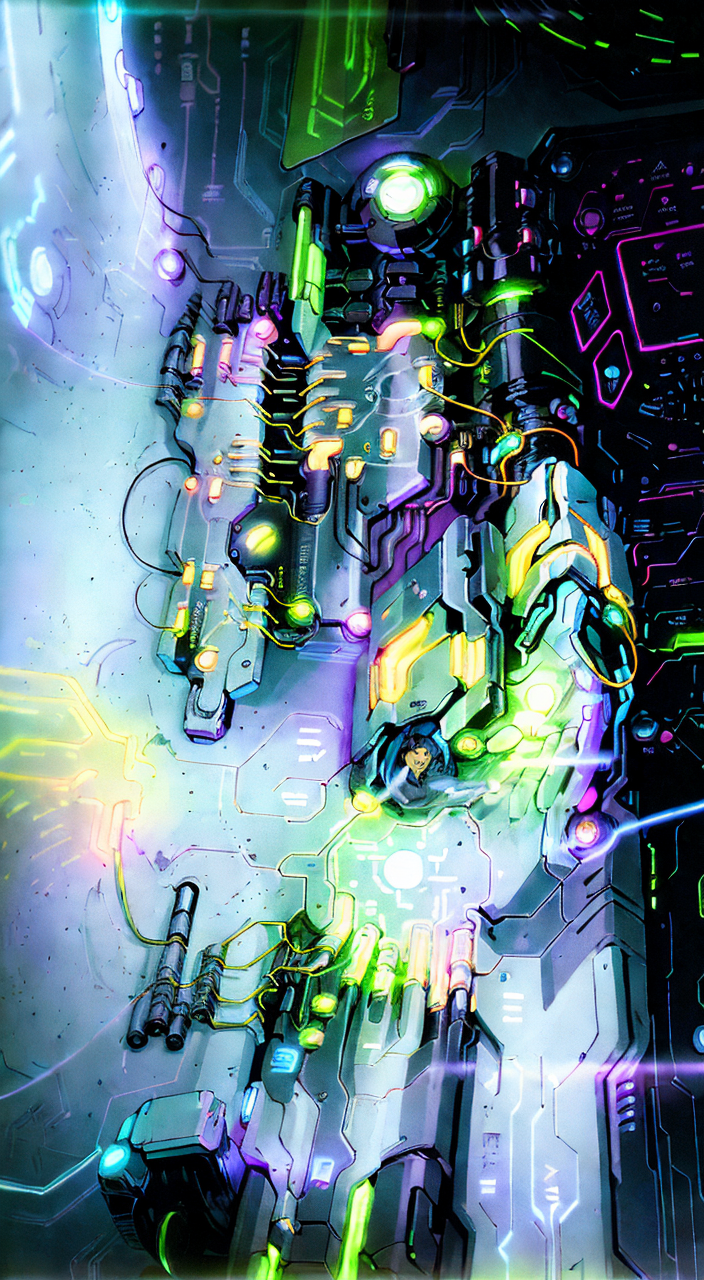

In [ ]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 720 #@param
    H = 1280 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 32 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'dpm2_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 35 #@param
    scale = 14 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "Cumanda14" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = True #@param {type:"boolean"}
    strength = 1.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "/content/drive/MyDrive/AI/ScreenShots/Gusano1.jpg" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.01 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}

    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast'
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# get prompts
cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

# Create Video From Frames

In [ ]:
#@markdown **New Version**
skip_video_for_run_all = True #@param {type: 'boolean'}
create_gif = False #@param {type: 'boolean'}

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:

    from helpers.ffmpeg_helpers import get_extension_maxframes, get_auto_outdir_timestring, get_ffmpeg_path, make_mp4_ffmpeg, make_gif_ffmpeg, patrol_cycle

    def ffmpegArgs():
        ffmpeg_mode = "auto" #@param ["auto","manual","timestring"]
        ffmpeg_outdir = "" #@param {type:"string"}
        ffmpeg_timestring = "" #@param {type:"string"}
        ffmpeg_image_path = "" #@param {type:"string"}
        ffmpeg_mp4_path = "" #@param {type:"string"}
        ffmpeg_gif_path = "" #@param {type:"string"}
        ffmpeg_extension = "png" #@param {type:"string"}
        ffmpeg_maxframes = 200 #@param
        ffmpeg_fps = 12 #@param

        # determine auto paths
        if ffmpeg_mode == 'auto':
            ffmpeg_outdir, ffmpeg_timestring = get_auto_outdir_timestring(args,ffmpeg_mode)
        if ffmpeg_mode in ["auto","timestring"]:
            ffmpeg_extension, ffmpeg_maxframes = get_extension_maxframes(args,ffmpeg_outdir,ffmpeg_timestring)
            ffmpeg_image_path, ffmpeg_mp4_path, ffmpeg_gif_path = get_ffmpeg_path(ffmpeg_outdir, ffmpeg_timestring, ffmpeg_extension)
        return locals()

    ffmpeg_args_dict = ffmpegArgs()
    ffmpeg_args = SimpleNamespace(**ffmpeg_args_dict)
    make_mp4_ffmpeg(ffmpeg_args, display_ffmpeg=True, debug=False)
    if create_gif:
        make_gif_ffmpeg(ffmpeg_args, debug=False)
    #patrol_cycle(args,ffmpeg_args)

# Disconnect Runtime

In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()